# Predicting Sentiment in Tweets Involving the Dallas Mavericks

#### Brian Johns, May 2023

## Notebook #2: Feature Engineering & NLP

In notebook #1, I gathered and cleaned the data.  However, to make data ready for modeling, the data will require Natural Language Processing (NLP).  There is also additional information that could be gathered that could help us make our models more predictive and helpful for future use.

In this notebook, I will do the following:

1. [Load Data](#loading)
2. [Feature Engineering](#features)
3. [Text Vectorization](#NLP)
4. [Prepping Data ready for modeling](#prepping)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

import geonamescache

import unidecode

import regex as re

import pickle

import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianjohns/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/brianjohns/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<a id = 'loading'></a>

## 1. Load Data

In [2]:
mavs_df = pd.read_pickle('mavs_sentiment.pickle')

In [3]:
mavs_df.head()

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Twitter Access Point,Follower Count,Friends Count,verified,Positive,Neutral,Negative,Compound,Sentiment
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,UNITED STATES,1,0,0,Twitter for Android,4073,3248,False,0.000,0.722,0.278,-0.6124,Negative
1,2022-06-01 18:53:27-05:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,TEXAS,0,0,8,Twitter for iPhone,341,219,False,0.443,0.557,0.000,0.9722,Positive
2,2022-06-01 18:51:11-05:00,1532147780663316485,Dallas Mavericks Get Ripped To Shreds For ‘Hon...,RL26VA,UNITED STATES,0,0,0,Twitter for Android,4073,3248,False,0.000,0.909,0.091,-0.3182,Negative
3,2022-06-01 18:50:42-05:00,1532147657153695744,Hey @mcuban do the city of Dallas a favor sign...,DKylesBoi,DALLAS,0,0,0,Twitter for iPhone,1348,154,True,0.227,0.773,0.000,0.7562,Positive
4,2022-06-01 18:44:12-05:00,1532146022679465984,@lynchscott41 @jcjp17 @dallasmavsshop @dallasm...,JebusBlonde,TEXAS,0,0,0,Twitter for iPhone,58,308,False,0.218,0.782,0.000,0.4696,Positive


To later help with analyzing the NLP process, I will use a function that will show me the words with the highest weighting using TFIDF and determine steps to take to improve the NLP process.

In [4]:
def plot_most_frequent(bagofwords, X_train_transformed, top=20):
    '''
    A function that will plot the most common words within a vectorized dataset
    
    Parameters
    ----------
    bagofwords: Text that has been processed and vectorized
    
    X_train_transformed: Training data that has been transformed with the bagofwords
    
    top: The number of tokens displayed, in ranked order by the weight of their distribution from the vectorization.
    defaulted to 20
    
    Output
    ------
    Barplot that will display the Top 20 (by default) tokens that have the highest weight within the vectorization.
    '''
    
    # Getting the tokens
    words = bagofwords.get_feature_names_out()
    
    # Getting weights of the tokens
    word_weights = X_train_transformed.toarray().sum(axis = 0)
    
    # Placing them in a dataframe
    words_df = pd.DataFrame({"token": words, 
                             "weights": word_weights})
    
    # Plotting off of the dataframe
    fig, ax = plt.subplots(figsize=(10, 0.5*top))
    words_df.sort_values(by="weights", ascending=True).tail(top)\
        .set_index("token")\
        .plot(kind="barh", ax=ax)
    sns.despine()
    plt.title("Tokens with the Greatest Total Weight")
    plt.show()

<a id = 'features'></a>

## 2. Feature Engineering

There is quite a few things to do to add some more features to the data set and to make the current data more useable for modeling.  There are some features that will be easy to develop, whereas others will take some more work.  Here are the goals:

1. Binarize whether the user is `verified`
2. Bin/Dummy the `Twitter Access Point`
3. Extract useful `Datetime` aspects, particularly the hour of the day and day of the week.
4. Create a `Day_Of_Season` feature to reflect how far into the season the tweet was made. This way the numbers will accurately represent the amount of duration that has passed during the season, rather than using the literal datetime days.
5. Using `Datetime` and cross-referencing with game results, I want to mark the days that the Mavericks had a game, and whether or not they won that game, and see if that is predictive of `Sentiment`
6. Using the W/L record, I want to see if `Sentiment` is related to the teams winning percentage at the time of the tweet.
7. With the work done cleaning `Location`, here I will dummify the column.
8. Determine use of `Username`

Once this feature engineering has been completed, then I will Vectorize `Text` and prepare the data to be ready for modeling.  this will include dropping `Tweet Id` and the Vader score components (`Positive`, `Negative`, `Neutral` and `Compound` scores.

It is unlikely that the `Tweet Id` provides any useful information outside of being an identifier for the tweet, so it will be dropped.

For the scores, `Compound` was used to create the target variable `Sentiment`, and the `Compound` scores were created with the other 3 scores, so all of this is captured in the target so will be dropped from the features.

`Friends Count` and `Followers Count` are both numeric, so they will be kept as is for now, but binning them may be a better option and can be determined later.

### 1. Binarize `verified`

In [5]:
mavs_df['Verified'] = np.where(mavs_df['verified'] == True, 1, 0)

In [6]:
mavs_df.head()

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Twitter Access Point,Follower Count,Friends Count,verified,Positive,Neutral,Negative,Compound,Sentiment,Verified
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,UNITED STATES,1,0,0,Twitter for Android,4073,3248,False,0.000,0.722,0.278,-0.6124,Negative,0
1,2022-06-01 18:53:27-05:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,TEXAS,0,0,8,Twitter for iPhone,341,219,False,0.443,0.557,0.000,0.9722,Positive,0
2,2022-06-01 18:51:11-05:00,1532147780663316485,Dallas Mavericks Get Ripped To Shreds For ‘Hon...,RL26VA,UNITED STATES,0,0,0,Twitter for Android,4073,3248,False,0.000,0.909,0.091,-0.3182,Negative,0
3,2022-06-01 18:50:42-05:00,1532147657153695744,Hey @mcuban do the city of Dallas a favor sign...,DKylesBoi,DALLAS,0,0,0,Twitter for iPhone,1348,154,True,0.227,0.773,0.000,0.7562,Positive,1
4,2022-06-01 18:44:12-05:00,1532146022679465984,@lynchscott41 @jcjp17 @dallasmavsshop @dallasm...,JebusBlonde,TEXAS,0,0,0,Twitter for iPhone,58,308,False,0.218,0.782,0.000,0.4696,Positive,0


In [7]:
mavs_df = mavs_df.drop(columns = 'verified')

In [8]:
mavs_df.head()

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Twitter Access Point,Follower Count,Friends Count,Positive,Neutral,Negative,Compound,Sentiment,Verified
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,UNITED STATES,1,0,0,Twitter for Android,4073,3248,0.000,0.722,0.278,-0.6124,Negative,0
1,2022-06-01 18:53:27-05:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,TEXAS,0,0,8,Twitter for iPhone,341,219,0.443,0.557,0.000,0.9722,Positive,0
2,2022-06-01 18:51:11-05:00,1532147780663316485,Dallas Mavericks Get Ripped To Shreds For ‘Hon...,RL26VA,UNITED STATES,0,0,0,Twitter for Android,4073,3248,0.000,0.909,0.091,-0.3182,Negative,0
3,2022-06-01 18:50:42-05:00,1532147657153695744,Hey @mcuban do the city of Dallas a favor sign...,DKylesBoi,DALLAS,0,0,0,Twitter for iPhone,1348,154,0.227,0.773,0.000,0.7562,Positive,1
4,2022-06-01 18:44:12-05:00,1532146022679465984,@lynchscott41 @jcjp17 @dallasmavsshop @dallasm...,JebusBlonde,TEXAS,0,0,0,Twitter for iPhone,58,308,0.218,0.782,0.000,0.4696,Positive,0


### 2. Bin/Dummy `Twitter Access Point`

In [9]:
mavs_df['Twitter Access Point'].value_counts()

Twitter for iPhone      132675
Twitter for Android      52635
Twitter Web App          41274
dlvr.it                   5604
WordPress.com             3684
                         ...  
TwitPane for Android         1
Chupagoat                    1
News Autopublish App         1
agdeporaut                   1
Urban hotness                1
Name: Twitter Access Point, Length: 693, dtype: int64

In [10]:
mavs_df.loc[(mavs_df['Twitter Access Point'] != 'Twitter for iPhone') &
            (mavs_df['Twitter Access Point'] != 'Twitter for Android') &
            (mavs_df['Twitter Access Point'] != 'Twitter Web App')].value_counts().sum()

36332

With this, it would seem to be appropriate to have 4 'categories' for Twitter Access Point:

1. iPhone
2. Android
3. Web App
4. Other

I'll re-label the Access Point to 'Other' and then dummify the column to keep the iPhone, Android and Web App data.

In [11]:
mavs_df.loc[(mavs_df['Twitter Access Point'] != 'Twitter for iPhone') &
            (mavs_df['Twitter Access Point'] != 'Twitter for Android') &
            (mavs_df['Twitter Access Point'] != 'Twitter Web App'), 'Twitter Access Point'] = 'Other'

mavs_df.loc[(mavs_df['Twitter Access Point'] == 'Twitter for iPhone'), 'Twitter Access Point'] = 'iPhone'
mavs_df.loc[(mavs_df['Twitter Access Point'] == 'Twitter for Android'), 'Twitter Access Point'] = 'Android'
mavs_df.loc[(mavs_df['Twitter Access Point'] == 'Twitter Web App'), 'Twitter Access Point'] = 'Web_App'

In [12]:
mavs_df = pd.get_dummies(mavs_df, prefix = 'Access', columns = ['Twitter Access Point'])
mavs_df = mavs_df.drop(columns = 'Access_Other')

In [13]:
mavs_df.head()

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Follower Count,Friends Count,Positive,Neutral,Negative,Compound,Sentiment,Verified,Access_Android,Access_Web_App,Access_iPhone
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,UNITED STATES,1,0,0,4073,3248,0.000,0.722,0.278,-0.6124,Negative,0,1,0,0
1,2022-06-01 18:53:27-05:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,TEXAS,0,0,8,341,219,0.443,0.557,0.000,0.9722,Positive,0,0,0,1
2,2022-06-01 18:51:11-05:00,1532147780663316485,Dallas Mavericks Get Ripped To Shreds For ‘Hon...,RL26VA,UNITED STATES,0,0,0,4073,3248,0.000,0.909,0.091,-0.3182,Negative,0,1,0,0
3,2022-06-01 18:50:42-05:00,1532147657153695744,Hey @mcuban do the city of Dallas a favor sign...,DKylesBoi,DALLAS,0,0,0,1348,154,0.227,0.773,0.000,0.7562,Positive,1,0,0,1
4,2022-06-01 18:44:12-05:00,1532146022679465984,@lynchscott41 @jcjp17 @dallasmavsshop @dallasm...,JebusBlonde,TEXAS,0,0,0,58,308,0.218,0.782,0.000,0.4696,Positive,0,0,0,1


### 3. Datetime: Hour and Day of Week

In [14]:
mavs_df['Hour'] = mavs_df['Datetime'].dt.hour

In [15]:
mavs_df['Day'] = mavs_df['Datetime'].dt.dayofweek

In [16]:
mavs_df.head()

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Follower Count,Friends Count,...,Neutral,Negative,Compound,Sentiment,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,Day
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,UNITED STATES,1,0,0,4073,3248,...,0.722,0.278,-0.6124,Negative,0,1,0,0,18,2
1,2022-06-01 18:53:27-05:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,TEXAS,0,0,8,341,219,...,0.557,0.000,0.9722,Positive,0,0,0,1,18,2
2,2022-06-01 18:51:11-05:00,1532147780663316485,Dallas Mavericks Get Ripped To Shreds For ‘Hon...,RL26VA,UNITED STATES,0,0,0,4073,3248,...,0.909,0.091,-0.3182,Negative,0,1,0,0,18,2
3,2022-06-01 18:50:42-05:00,1532147657153695744,Hey @mcuban do the city of Dallas a favor sign...,DKylesBoi,DALLAS,0,0,0,1348,154,...,0.773,0.000,0.7562,Positive,1,0,0,1,18,2
4,2022-06-01 18:44:12-05:00,1532146022679465984,@lynchscott41 @jcjp17 @dallasmavsshop @dallasm...,JebusBlonde,TEXAS,0,0,0,58,308,...,0.782,0.000,0.4696,Positive,0,0,0,1,18,2


### 4. Datetime: Amount of Time since the Start of the Season

In [17]:
mavs_df['Day_Of_Season'] = 0

The data is already ordered in reverse chronological order (the first line in the data is the last tweet that was sent).  I'll leverage this order in order to determine the number of days since the start of the season it was.

In [18]:
# Getting the timestamp of the very last line in the data, which is the tweet that was actually sent FIRST!
first_tweet = mavs_df['Datetime'][mavs_df.shape[0]-1]

for n in list(range(0, mavs_df.shape[0])):
    # Subtract the first tweet timestamp from the timestamp of each tweet to determine how many days into the season
    # the tweet was sent
    mavs_df['Day_Of_Season'][n] = (mavs_df['Datetime'][n] - first_tweet).days+1

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/832790798.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mavs_df['Day_Of_Season'][n] = (mavs_df['Datetime'][n] - first_tweet).days+1


An earlier version of this analysis considering binning the time data into four categories: Pre-Season, Pre-All Star Game, Post-All Star Game and Postseason.  The code for this will be commented out here but saved in case it is a better alternative for using the time of the tweet to predict its sentiment.

In [19]:
#I believe that binning some `Datetime` information may be more helpful in engineering predictive features.

#First, I want to bin what time of year the tweet was sent relative to the season.
#Based on the timestamps, I believe this can be effectively placed into 4 bins:
#Preseason, Pre-All Star Game (just after the middle of the season), Post-#All Star Game, Postseason.
#This would not equally divide the number of tweets in the data
#but could represent four #time frames that could have distinct differences in `Sentiment`

# Decided that the Day of Season feature is a more appropriate way to show this information

#mavs_df['Date_Preseason'] = np.where(mavs_df['Datetime'] < '2021-10-21', 1, 0)
#mavs_df['Date_PreASG'] = np.where((mavs_df['Datetime'] >= '2021-10-21') & (mavs_df['Datetime'] < '2022-02-20'), 1, 0)
#mavs_df['Date_PostASG'] = np.where((mavs_df['Datetime'] >= '2022-02-20') & (mavs_df['Datetime'] < '2022-04-11'), 1, 0)
#mavs_df['Date_Postseason'] = np.where(mavs_df['Datetime'] >= '2022-04-10', 1, 0)

In [20]:
mavs_df.head(2)

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Follower Count,Friends Count,...,Negative,Compound,Sentiment,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,Day,Day_Of_Season
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,UNITED STATES,1,0,0,4073,3248,...,0.278,-0.6124,Negative,0,1,0,0,18,2,244
1,2022-06-01 18:53:27-05:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,TEXAS,0,0,8,341,219,...,0.000,0.9722,Positive,0,0,0,1,18,2,244


In [21]:
mavs_df.tail(2)

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Follower Count,Friends Count,...,Negative,Compound,Sentiment,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,Day,Day_Of_Season
262914,2021-09-30 19:01:58-05:00,1443727854869569545,@Dallas014 @NBCDFW @dallasmavs @AACenter Cry s...,Breakfast_Fan,UNKNOWN,1,0,1,210,889,...,0.341,-0.4767,Negative,0,0,1,0,19,3,1
262915,2021-09-30 19:00:19-05:00,1443727441558638592,@notmbonly25 @BibsCorner @TonySalamino @dallas...,H_thereal1,UNKNOWN,0,0,0,14,60,...,0.216,-0.2960,Negative,0,0,1,0,19,3,1


This has appropriately put timeframes on each tweet in regards to the full season.

### 5/6. Add `Win`,  `Gameday` and `Winning_Pct` Features

I believe that there may be a change in `Sentiment` based off of the most recent game result

This may not be perfect, but some models may be able to take the hour of the day and the result of a game (such as late hours after a Loss) and see if it is predictive of `Sentiment`.

I was able to retrieve the results by downloading them from this link: https://www.basketball-reference.com/teams/DAL/2022_games.html.

In [22]:
web_df = pd.read_csv('mavs_schedule.txt', header = None)

In [23]:
web_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,Thu Oct 21 2021,7:30p,NaN,Box Score,@,Atlanta Hawks,L,NaN,87,113,0,1,L 1,NaN
1,2,Sat Oct 23 2021,7:30p,NaN,Box Score,@,Toronto Raptors,W,NaN,103,95,1,1,W 1,NaN
2,3,Tue Oct 26 2021,8:30p,NaN,Box Score,NaN,Houston Rockets,W,NaN,116,106,2,1,W 2,NaN
3,4,Thu Oct 28 2021,8:30p,NaN,Box Score,NaN,San Antonio Spurs,W,NaN,104,99,3,1,W 3,NaN
4,5,Fri Oct 29 2021,10:00p,NaN,Box Score,@,Denver Nuggets,L,NaN,75,106,3,2,L 1,NaN


This only columns of interest for this is '1', which is the date of the game, and '7', which is the result.

I will use the W/L column to add up the total Wins, Losses and calculate the Winning Percentage for the specific time each tweet was sent.

In [24]:
loss_counter = 0
win_counter = 0

web_df['Wins'] = 0
web_df['Losses'] = 0
web_df['Winning_Pct'] = 0

for n in list(range(0, web_df.shape[0])):
    if web_df[7][n] == 'L':
        loss_counter = loss_counter + 1
    if web_df[7][n] == 'W':
        win_counter = win_counter + 1
    web_df['Wins'][n] = win_counter
    web_df['Losses'][n] = loss_counter
    web_df['Winning_Pct'][n] = web_df['Wins'][n] / (web_df['Wins'][n] + web_df['Losses'][n])

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/2722341169.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  web_df['Wins'][n] = win_counter
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/2722341169.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  web_df['Losses'][n] = loss_counter
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/2722341169.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [25]:
web_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Wins,Losses,Winning_Pct
0,1,Thu Oct 21 2021,7:30p,NaN,Box Score,@,Atlanta Hawks,L,NaN,87,113,0,1,L 1,NaN,0,1,0.000000
1,2,Sat Oct 23 2021,7:30p,NaN,Box Score,@,Toronto Raptors,W,NaN,103,95,1,1,W 1,NaN,1,1,0.500000
2,3,Tue Oct 26 2021,8:30p,NaN,Box Score,NaN,Houston Rockets,W,NaN,116,106,2,1,W 2,NaN,2,1,0.666667
3,4,Thu Oct 28 2021,8:30p,NaN,Box Score,NaN,San Antonio Spurs,W,NaN,104,99,3,1,W 3,NaN,3,1,0.750000
4,5,Fri Oct 29 2021,10:00p,NaN,Box Score,@,Denver Nuggets,L,NaN,75,106,3,2,L 1,NaN,3,2,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Wed May 18 2022,9:00p,NaN,Box Score,@,Golden State Warriors,L,NaN,87,112,8,6,L 1,NaN,60,36,0.625000
96,97,Fri May 20 2022,9:00p,NaN,Box Score,@,Golden State Warriors,L,NaN,117,126,8,7,L 2,NaN,60,37,0.618557
97,98,Sun May 22 2022,9:00p,NaN,Box Score,NaN,Golden State Warriors,L,NaN,100,109,8,8,L 3,NaN,60,38,0.612245
98,99,Tue May 24 2022,9:00p,NaN,Box Score,NaN,Golden State Warriors,W,NaN,119,109,9,8,W 1,NaN,61,38,0.616162


Now, I'll create a dataframe of just this information, and then I will loop through all of the data in order to match the month and day values.  If the values match with a game date, then the corresponding result will be recorded on the main dataframe.

In [26]:
date_result = web_df[[1,7, 'Winning_Pct']]

In [27]:
date_result[1] = pd.to_datetime(date_result[1], utc = True)

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/2913532212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_result[1] = pd.to_datetime(date_result[1], utc = True)


In [28]:
date_result = date_result.rename(columns = {1:'Date', 7:'Result'})

In [29]:
date_result

,Date,Result,Winning_Pct
0,2021-10-21 00:00:00+00:00,L,0.000000
1,2021-10-23 00:00:00+00:00,W,0.500000
2,2021-10-26 00:00:00+00:00,W,0.666667
3,2021-10-28 00:00:00+00:00,W,0.750000
4,2021-10-29 00:00:00+00:00,L,0.600000
...,...,...,...
95,2022-05-18 00:00:00+00:00,L,0.625000
96,2022-05-20 00:00:00+00:00,L,0.618557
97,2022-05-22 00:00:00+00:00,L,0.612245
98,2022-05-24 00:00:00+00:00,W,0.616162


In [30]:
mavs_df['Win'] = 0
mavs_df['Gameday'] = 0
mavs_df['Winning_Pct'] = 0

In [31]:
# This one takes a while!
for n in range(0, mavs_df.shape[0]):
    for m in range(0, date_result.shape[0]):
        if mavs_df['Datetime'][n].month == date_result['Date'][m].month:
            if mavs_df['Datetime'][n].day == date_result['Date'][m].day:
                mavs_df['Winning_Pct'][n] = date_result['Winning_Pct'][m]
                mavs_df['Gameday'][n] = 1
                if date_result['Result'][m] == 'W':
                    mavs_df['Win'][n] = 1
                #elif date_result['Result'][m] == 'L':
                 #   mavs_df['Loss'][n] = 1
                #else:
                 #   pass

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/697031679.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mavs_df['Winning_Pct'][n] = date_result['Winning_Pct'][m]
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/697031679.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mavs_df['Gameday'][n] = 1
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/697031679.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [32]:
# The above code will only put the Winning Percentage on the specific day of the tweet.
# back filling all of the zeroes preciding it will ensure the Winning Percentage is used for every tweet
# Until the next time Dallas wins or loses a game, whether it's the next day or a week later
mavs_df['Winning_Pct'] = mavs_df['Winning_Pct'].replace(to_replace = 0, method = 'bfill')

In [33]:
mavs_df[mavs_df['Win'] == 1].head()

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Follower Count,Friends Count,...,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,Day,Day_Of_Season,Win,Gameday,Winning_Pct
14366,2022-05-24 23:59:57-05:00,1529326381070536704,Golden State Warriors vs Dallas Mavericks Game...,AlissaNba,UNKNOWN,0,0,0,34,55,...,0,0,1,0,23,1,237,1,1,0.616162
14367,2022-05-24 23:59:47-05:00,1529326341400604672,@NBA @dallasmavs ...you only win 1 game and th...,leon_wm,UNKNOWN,0,0,0,5,36,...,0,1,0,0,23,1,237,1,1,0.616162
14368,2022-05-24 23:59:11-05:00,1529326187079663616,@NBA @dallasmavs Of course they have the power...,aliabolela7,UNKNOWN,0,0,0,57,23,...,0,0,0,1,23,1,237,1,1,0.616162
14369,2022-05-24 23:59:07-05:00,1529326173490225153,@KohlRastman67 @dallasmavs I've been listening...,benaggie,TEXAS,1,0,23,484,4995,...,0,0,1,0,23,1,237,1,1,0.616162
14370,2022-05-24 23:59:02-05:00,1529326152556261376,@NBA @dallasmavs People mad for players believ...,curry_goated30,UNKNOWN,3,0,70,1548,1183,...,0,1,0,0,23,1,237,1,1,0.616162


According to basketball reference, these are correctly recorded.

### 7. Dummy `Location`

In [34]:
mavs_df = pd.get_dummies(mavs_df, prefix = 'Location', columns = ['location'])

In [35]:
mavs_df = mavs_df.drop(columns = 'Location_UNKNOWN')

In [36]:
mavs_df.head()

,Datetime,Tweet Id,Text,Username,reply count,retweet count,like count,Follower Count,Friends Count,Positive,...,Hour,Day,Day_Of_Season,Win,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,1,0,0,4073,3248,0.000,...,18,2,244,0,0,0.61,0,0,0,1
1,2022-06-01 18:53:27-05:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,0,0,8,341,219,0.443,...,18,2,244,0,0,0.61,0,0,1,0
2,2022-06-01 18:51:11-05:00,1532147780663316485,Dallas Mavericks Get Ripped To Shreds For ‘Hon...,RL26VA,0,0,0,4073,3248,0.000,...,18,2,244,0,0,0.61,0,0,0,1
3,2022-06-01 18:50:42-05:00,1532147657153695744,Hey @mcuban do the city of Dallas a favor sign...,DKylesBoi,0,0,0,1348,154,0.227,...,18,2,244,0,0,0.61,1,0,0,0
4,2022-06-01 18:44:12-05:00,1532146022679465984,@lynchscott41 @jcjp17 @dallasmavsshop @dallasm...,JebusBlonde,0,0,0,58,308,0.218,...,18,2,244,0,0,0.61,0,0,1,0


### 8. `Username`

In [37]:
mavs_df.value_counts('Username', ascending = False)

Username
dallasmavs         2983
Hoops227_NFL       2851
AlbertaPark19      2468
BallySportsSW      1511
Mavs_Win            651
                   ... 
NormaAceves28         1
Norj08021999          1
NoriahWWinds          1
NorCalWaters          1
zzzzzzz67184842       1
Length: 92902, dtype: int64

Keeping every user in this data is impractical and likely unhelpful for further analysis.  My hypothesis is that the *frequency* a user tweets may be predictive of the users `Sentiment`.  For instance, perhaps users that tweet frequently (such as the Dallas Mavericks official twitter account) are more positive, whereas the less frequent users will do so only to voice their displeasure.

With 35 weeks of data, I'll try to break this down to users that tweet Weekly (have more than 35 total tweets), Monthly (have between 8-35 tweets total), Infrequently (less than 8 but more than 1) and only Once.

In [38]:
username_df = mavs_df.value_counts('Username', ascending = False)

In [39]:
username_df[username_df.values > 35].count()

665

In [40]:
username_df[(username_df.values <= 35) & (username_df.values >= 8)].count()

4221

In [41]:
username_df[(username_df.values < 8) & (username_df.values > 1)].count()

24765

In [42]:
username_df[username_df.values == 1].count()

63251

It would seem that binning username by the number of tweets may be a more effective way to have user data.  Seeing trends between frequent tweets and those that periodically tweet about the Dallas Mavericks could prove insightful.

The vast majority of usernames (63,251 out of 92,902) had exactly 1 tweet during this time frame.

There are also 243 total days, 35 weeks and 8 months captured in the data.  Perhaps this is how usernames could be binned:

- Tweets_Weekly: 665 Users
- Tweets_Monthly: 4221 Users
- Tweets_Infrequent (Less than monthly, more than one total): 24675 Users
- Tweets_Once: 63251 Users

With this balance, perhaps some insights could be made about how frequent a user tweets during the course of the season.

In [43]:
# List of names for each category
weekly = list(username_df[username_df.values > 35].index)
monthly = list(username_df[(username_df.values <= 35) & (username_df.values >= 8)].index)
infrequent = list(username_df[(username_df.values < 8) & (username_df.values > 1)].index)

In [44]:
weekly

['dallasmavs',
 'Hoops227_NFL',
 'AlbertaPark19',
 'BallySportsSW',
 'Mavs_Win',
 'JohnStanleyNBA',
 'BenHilly94',
 'NBA',
 'btcbettingtips',
 'jalenxvi',
 'BigDFans',
 'Alexand65504397',
 'mavsmoneyball',
 'Dallas__Nation',
 'stakehighroller',
 'NBATopPerformer',
 'imaMaverick20',
 'sportsnews2022',
 'cappertek',
 'YourboyLM',
 '4StateNews',
 'colby_burner',
 'LiveTokenBot',
 'stakesportsbet',
 'dick_nowitzki',
 'MavsFansForLife',
 'VCPHoops',
 'AggTownUglyMann',
 'Doporto21',
 '_mcflyboi_',
 'qctimes',
 'TXBossBabe41',
 '_Tommy76_',
 'D210S',
 'dallas_hoops',
 'PatrikEngineer',
 'PcRoccoGaming',
 'SultanBurhanul',
 'ItsMrMilton',
 'knight93king',
 'Chiran77LD',
 'MDyey21',
 'We_Luv_Juan',
 'redditmavericks',
 'GSMLBPicks',
 'RyoRyo719',
 'KatysMyHabibi',
 'sixfivelando',
 'SBIAAlerts',
 'MavrelloB',
 'JefferySplash',
 'NBAIndia',
 'ElijahL29913032',
 'bnzMavs',
 'debrawelchtx',
 'kslsports',
 'JanjaKp1',
 'GlazeLogan',
 'paolothecatdad',
 'ddpage369',
 'BradfatherSpeak',
 'annakorbel

In [45]:
monthly

['SkyNetPlatform',
 'MrHarryBoughner',
 'DallasHighlight',
 'ChillTre_',
 'shinkiong',
 'MogCrack',
 'SPORTSCIRCUSINT',
 'SiriusXMNBA',
 'DurenZach',
 'jaythru_',
 'JohnnyKF17',
 'Sportsnet',
 'jrcards777',
 'Shakinmybakin',
 'InevGaming',
 'MavsBurner',
 'kmstx78',
 'TyWalker716',
 'EZRlistening',
 'crock_meg',
 'dmurry',
 'MavsStan41',
 'ishthechosenone',
 'RBsSportsPlays',
 'lampdizl',
 'harodrio1',
 'DBeyreis',
 'pete13213066',
 'SpotOn96057010',
 'TheDarthliticus',
 'MileHighAngel7',
 'GibbonNicola',
 'NBA_Mavs41',
 'Glenjr1988',
 'TopDataNBA_Live',
 'nikgazcs2',
 'cumbiacalnte76',
 'nat3_22',
 'Justine433333',
 'sltrib',
 'Goaloo_sports',
 'NBA_Math',
 'AACenter',
 'Bron_In_His_Bag',
 'whoyeah57',
 'PamelaGStiles',
 'courageeeee__',
 'Masonthecool97',
 'TheRealAlexis',
 'garyjohnson74',
 'Carlos_Ba3',
 'PiotrKT77',
 'maggiejuang1',
 'WhatCommonSens',
 'TomZarebczan',
 'Chris19983541',
 'BurnerAlternate',
 'SadMavs_Fan',
 'jack__howe',
 'TheAddisfaction',
 'sitedataseo',
 'MavsOff

In [46]:
infrequent

['msswpr',
 'Cyril2003M',
 'NBAFAN23236',
 'ETBSports',
 'lynchscott41',
 'MalcolmChex22',
 'mikless94',
 'thompson11_ju',
 'garywpatterson1',
 '777_xpose',
 'ItsBlomo',
 'Shane_Brand34',
 'JP6694',
 'sportingnews',
 'GarrenLephan',
 'xhristopherus',
 'QuantChild',
 'GarrisonMoratto',
 'justTerrence_',
 'IncWebber',
 'sergio_indigo',
 'Alejandro_t9',
 'TomFoxPhoto',
 'BkcSports',
 'MigglesPuta',
 'Sneaker6ueen',
 '_SantiMagic',
 'Sorosh2000',
 'Sthe_Notywala',
 'ryanlandry6712',
 'TomSullBoston1',
 'stripclub44',
 'Mountrushmores1',
 'NBARealTalk75',
 'PresidentOfFart',
 'markbernardo96',
 'GabrielBriian',
 'HerschyTheGreat',
 'TheMindofMyron',
 'TonyFayPR',
 'etdbrief_ro_1',
 'BallySports',
 'djzee_couture',
 'john94143748',
 'klaylavine',
 'vernonhadnot',
 'newswall_org',
 'yaboiAustin44',
 'e_newsUS',
 'TonyBonesDenham',
 'chron',
 'TyBamlin',
 'baegopahPanda',
 'brakowjr',
 'E_Sanchez24',
 'SP0RTSGEEK',
 'brakzx',
 'DickSully',
 'newsinvideos',
 'SOicyKD',
 'russell_todd17',
 'jaay

In [47]:
mavs_df['Tweets_Weekly'] = 0
mavs_df['Tweets_Monthly'] = 0
mavs_df['Tweets_Infrequent'] = 0

In [48]:
for n in range(mavs_df.shape[0]):
    if mavs_df['Username'][n] in weekly:
        mavs_df['Tweets_Weekly'][n] = 1
    elif mavs_df['Username'][n] in monthly:
        mavs_df['Tweets_Monthly'][n] = 1
    elif mavs_df['Username'][n] in infrequent:
        mavs_df['Tweets_Infrequent'][n] = 1

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/575629038.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mavs_df['Tweets_Infrequent'][n] = 1
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/575629038.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mavs_df['Tweets_Monthly'][n] = 1
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50944/575629038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [49]:
mavs_df['Tweets_Weekly'].value_counts()

0    198320
1     64596
Name: Tweets_Weekly, dtype: int64

In [50]:
mavs_df['Tweets_Monthly'].value_counts()

0    202570
1     60346
Name: Tweets_Monthly, dtype: int64

In [51]:
mavs_df['Tweets_Infrequent'].value_counts()

0    188193
1     74723
Name: Tweets_Infrequent, dtype: int64

In [52]:
username_df[username_df.values == 1].count()

63251

Perhaps I can visualize this better to see the distribution of each of these columns.

In [53]:
tweet_dict = {'Tweets_Weekly': mavs_df['Tweets_Weekly'].value_counts()[1], 
              'Tweets_Monthly': mavs_df['Tweets_Monthly'].value_counts()[1],
              'Tweets_Infrequent': mavs_df['Tweets_Infrequent'].value_counts()[1],
              'One_Tweet': username_df[username_df.values == 1].count()}

In [54]:
keys = list(tweet_dict.keys())

In [55]:
values = [int(tweet_dict[k]) for k in keys]

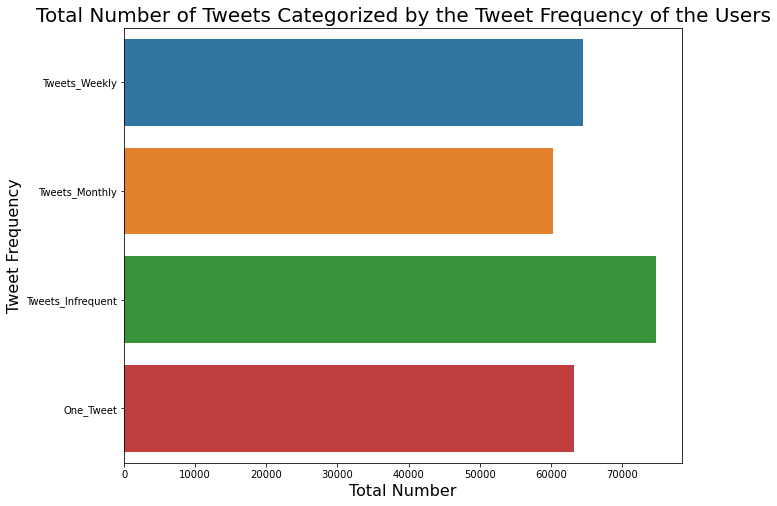

In [56]:
plt.figure(figsize = (10, 8))

sns.barplot(y = keys,
            x = values)
plt.xlabel('Total Number', fontsize = 16)
plt.ylabel('Tweet Frequency', fontsize = 16)
plt.title('Total Number of Tweets Categorized by the Tweet Frequency of the Users', fontsize = 20)

plt.show()

While the number of users for each category is not balanced, categorizing each tweet by how frequently the user tweets about the Dallas Mavericks is a relatively balanced distribution and could provide some pertinent insights.

Now I'd like to visualize these categories to see if there is much differentiation.

In [57]:
mavs_df.head(1)

,Datetime,Tweet Id,Text,Username,reply count,retweet count,like count,Follower Count,Friends Count,Positive,...,Win,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES,Tweets_Weekly,Tweets_Monthly,Tweets_Infrequent
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,1,0,0,4073,3248,0.0,...,0,0,0.61,0,0,0,1,0,0,1


In [58]:
columns = mavs_df.iloc[:, -3:].columns

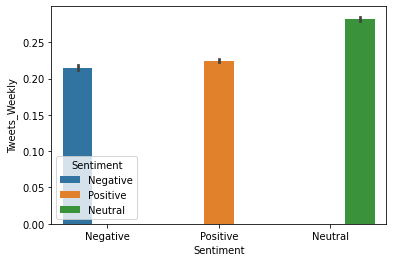

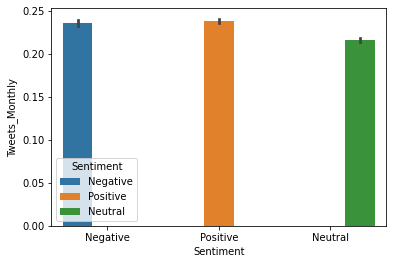

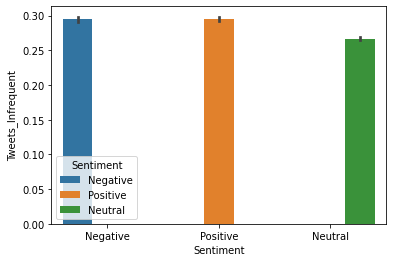

In [59]:
for col in columns:
    sns.barplot(x = 'Sentiment',
                   y = col,
                   hue = 'Sentiment',
                   data = mavs_df)
    plt.show()

In [60]:
tweet_once_df = mavs_df.loc[(mavs_df['Tweets_Weekly'] == 0) &
            (mavs_df['Tweets_Monthly'] == 0) &
            (mavs_df['Tweets_Infrequent'] == 0)]

In [61]:
tweet_once_groupby = tweet_once_df.groupby('Sentiment').count()

<AxesSubplot:xlabel='Sentiment', ylabel='Datetime'>

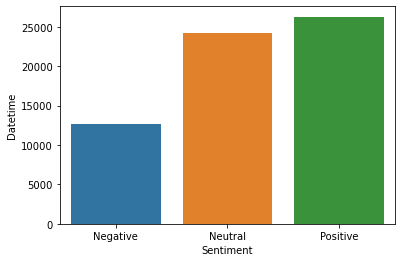

In [62]:
sns.barplot(x = tweet_once_groupby.index,
            y = tweet_once_groupby['Datetime'])

There does seem to be a small difference in the relationship in the users tweeting frequency and sentiment.  It seems that the most frequent tweeters are more neutral, those that tweet once are significantly less negative, whereas Monthly and Infreqeunt tweeters are less neutral (though more balanced).  This could have some predictive power when modeling.  With this I will drop the username of the tweets.

In [63]:
mavs_df = mavs_df.drop(columns = ['Username'])

<a id = 'NLP'></a>

## 3. Vectorize `Text`

For this, I am going to use a Tfidf Vectorizer on the tweet data.  The tweets themselves were gathered by searching for 'Dallas Mavericks', so there will be a high propensity to include the team name in the tweet that will not be an effective means of predicting `Sentiment`.  Using Tfidf will help weight words appropriately in order to determine if they are helpful in future models.

The vectorization should be done on training data so that there is no data leakage in the words used for features in order to test future models.  Therefore I will do a train/test split here.

I will also do some additionally cleaning of the text to remove other mentions (marked with an '@' at the start of the word) from each tweet.

Then, I will do an initial evaluation of the tokens before changing the parameters of the Tfidf Vectorizer in order to strengthen the vectorization process.

In [64]:
# Replace the '@' with white space
reg = re.compile("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z t])|(w+://S+)")
tweet = []
for i in mavs_df["Text"]:
    tweet.append(reg.sub(" ", i))

In [65]:
# Initial cleaned text
mavs_df['Clean_Text'] = tweet

In [66]:
mavs_df = mavs_df.drop(columns = ['Text'])

In [67]:
mavs_df.head()

,Datetime,Tweet Id,reply count,retweet count,like count,Follower Count,Friends Count,Positive,Neutral,Negative,...,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES,Tweets_Weekly,Tweets_Monthly,Tweets_Infrequent,Clean_Text
0,2022-06-01 18:54:00-05:00,1532148490922606594,1,0,0,4073,3248,0.000,0.722,0.278,...,0,0.61,0,0,0,1,0,0,1,Dallas Mavericks Send Insane Tweet To Honor ...
1,2022-06-01 18:53:27-05:00,1532148352283992065,0,0,8,341,219,0.443,0.557,0.000,...,0,0.61,0,0,1,0,0,0,0,Thanks Dallas Mavericks for celebrating our ...
2,2022-06-01 18:51:11-05:00,1532147780663316485,0,0,0,4073,3248,0.000,0.909,0.091,...,0,0.61,0,0,0,1,0,0,1,Dallas Mavericks Get Ripped To Shreds For Hon...
3,2022-06-01 18:50:42-05:00,1532147657153695744,0,0,0,1348,154,0.227,0.773,0.000,...,0,0.61,1,0,0,0,0,0,0,Hey do the city of Dallas a favor sign and...
4,2022-06-01 18:44:12-05:00,1532146022679465984,0,0,0,58,308,0.218,0.782,0.000,...,0,0.61,0,0,1,0,0,0,1,You d rather support the date January ...


In [68]:
# Exporting this data as a pickle here for potential Time Series Analysis done at a later point.
with open('mavs_tsa.pickle', 'wb') as f:
    pickle.dump(mavs_df, f)

In [69]:
# Separating data between target and features for vectorization and future modelling
# Compound score was used to derive the Sentiment
# Positive, Neutral and Negative Scores were used to calculate Compound
# So all four columns will be dropped
X = mavs_df.drop(columns = ['Sentiment', 'Datetime', 'Tweet Id', 'Positive', 'Negative', 'Neutral', 'Compound'])
y = mavs_df['Sentiment']

In [70]:
X.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES,Tweets_Weekly,Tweets_Monthly,Tweets_Infrequent,Clean_Text
0,1,0,0,4073,3248,0,1,0,0,18,...,0,0.61,0,0,0,1,0,0,1,Dallas Mavericks Send Insane Tweet To Honor ...
1,0,0,8,341,219,0,0,0,1,18,...,0,0.61,0,0,1,0,0,0,0,Thanks Dallas Mavericks for celebrating our ...
2,0,0,0,4073,3248,0,1,0,0,18,...,0,0.61,0,0,0,1,0,0,1,Dallas Mavericks Get Ripped To Shreds For Hon...
3,0,0,0,1348,154,1,0,0,1,18,...,0,0.61,1,0,0,0,0,0,0,Hey do the city of Dallas a favor sign and...
4,0,0,0,58,308,0,0,0,1,18,...,0,0.61,0,0,1,0,0,0,1,You d rather support the date January ...


In [71]:
y

0         Negative
1         Positive
2         Negative
3         Positive
4         Positive
            ...   
262911    Positive
262912    Negative
262913    Negative
262914    Negative
262915    Negative
Name: Sentiment, Length: 262916, dtype: object

#### Train/Test Split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size=0.2,
                                                    random_state=77)

In [73]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

This is going to be the testing data that will be used once I have completed all of the processes for NLP and modeling.  I will be using the training data here to help shape the Vectorizor.  Then, in the next notebook, I will split the data again (into Training and Validation sets) in order to optimize my predictive models.

In my final notebook, I will apply the optimized text vectorization AND the best performing predictive model to the Test data that has been split out here.

With that, I will now move forward with NLP with the data that remains in this train/test split.

#### Tfidf Vectorization #1

In [74]:
bagofwords = TfidfVectorizer(max_features=2000)
mavs_tweets = bagofwords.fit_transform(X_train['Clean_Text'])

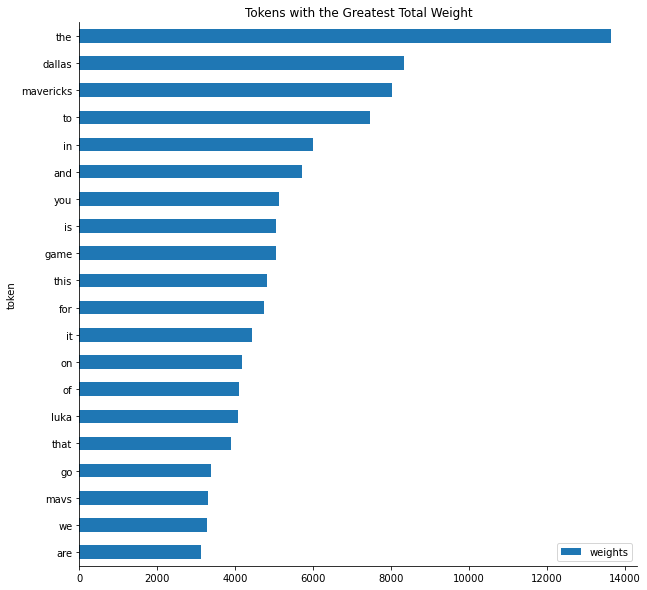

In [75]:
plot_most_frequent(bagofwords, mavs_tweets)

With the first generic go at it, it's clear we will have to do some significant modifications to the vectorizer.  Main ones will be:

1. Take out stop words
2. Append stop words to take out more generic basketball information (dallas, mavericks, nba, etc...)
3. Provide ngram_range to allow more variability on important tokens

#### Tfidf Vectorization #2: Stop Words

In [76]:
mavs_stopwords = ['chime', 'dallas', 'mavericks', 'mavs', 'nba', 'game', 'let', 'vs', 'just', 'like', 'youtube']

In [77]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(mavs_stopwords)

In [78]:
bagofwords = TfidfVectorizer(stop_words = my_stop_words,
                             ngram_range = (1, 3),
                             min_df = 5,
                             max_features = 2000)

In [79]:
mavs_tweets = bagofwords.fit_transform(X_train['Clean_Text'])

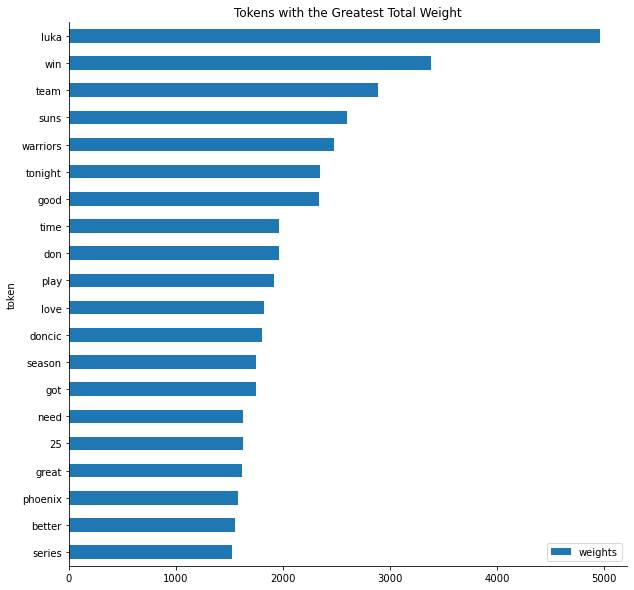

In [80]:
plot_most_frequent(bagofwords, mavs_tweets)

Seeing this, I think that there might be success to be had with a stemmer.  The names of teams and the names of players could be captured in the same stem.  Therefore I will start with a basic tokenizer that will stem the words.

#### Tfidf Vectorization #3: Stemming

In [81]:
def stem_tokenizer(tweet):
    listofwords = tweet.split(' ')
    listofstemmed_words = []
    
    stemmer = nltk.stem.PorterStemmer()
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in my_stop_words) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [82]:
bagofwords = TfidfVectorizer(tokenizer = stem_tokenizer,
                             stop_words = my_stop_words,
                             ngram_range = (1, 3),
                             min_df = 5,
                             max_features = 2000)

In [83]:
mavs_tweets = bagofwords.fit_transform(X_train['Clean_Text'])

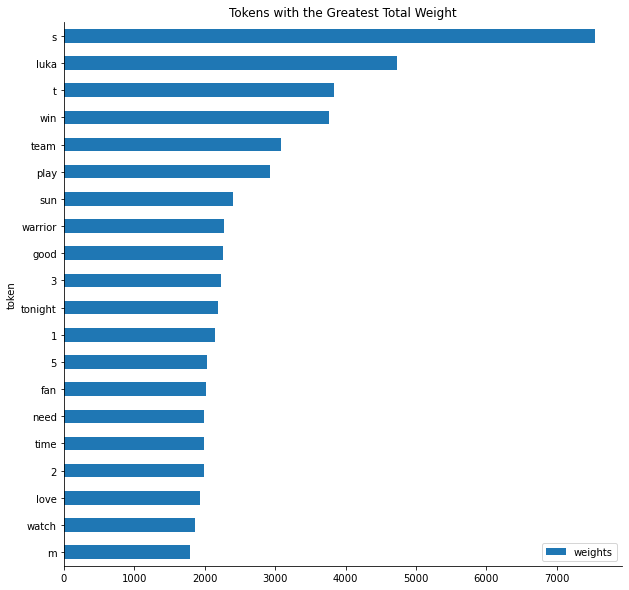

In [84]:
plot_most_frequent(bagofwords, mavs_tweets)

With this there is some mild success, but it appears that the punctuation used for twitter handles skews the words that are being captured.  I will re-create my tokenizer to not include numbers or single letters.

#### Tfidf Vectorization #4: Removing single letters/numbers with Stemming

In [85]:
single_letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
                 '...', '.', '\'']

In [86]:
number_list = [f'{i}' for i in range(0, 201)]

In [87]:
for num in number_list:
    mavs_stopwords.append(num)

In [88]:
for word in single_letters:
    mavs_stopwords.append(word)

In [89]:
mavs_stopwords

['chime',
 'dallas',
 'mavericks',
 'mavs',
 'nba',
 'game',
 'let',
 'vs',
 'just',
 'like',
 'youtube',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '12

In [90]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(mavs_stopwords)

In [91]:
bagofwords = TfidfVectorizer(tokenizer = stem_tokenizer,
                             ngram_range = (1, 3),
                             min_df = 5,
                             max_features = 2000)

In [92]:
mavs_tweets = bagofwords.fit_transform(X_train['Clean_Text'])

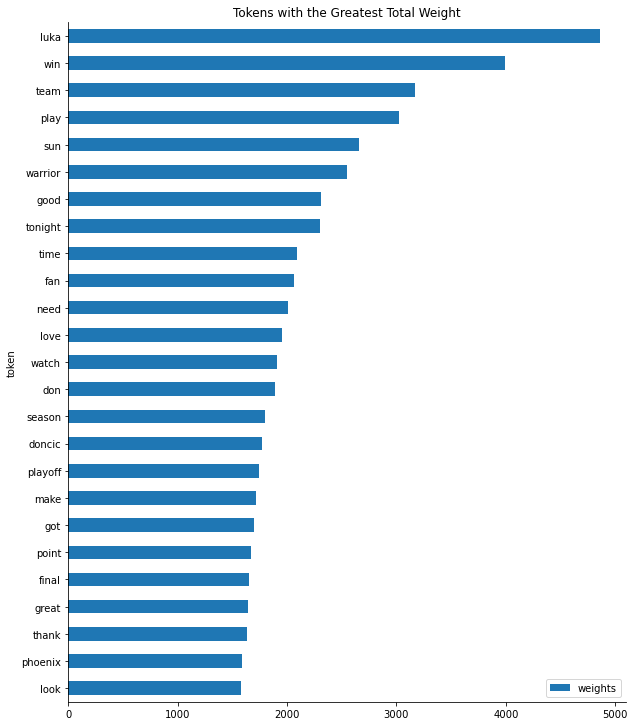

In [93]:
plot_most_frequent(bagofwords, mavs_tweets, 25)

Here we are getting results that could be more pertinent.  However, this has removed all of the twitter handles that would have been mentioned in a tweet, which could have some predictive value.

The stemming has not produced a lot of results at least for the most frequent tokens.

As a final step, I will try to lemmetize instead of stemming the text.  In a basketball context, there are a few contextual things that could help provide a better list of tokens (ie. playing vs players)

#### Tfidf Vectorization #5: Lemmitization

In [94]:
def lem_tokenizer(tweet):
    listofwords = tweet.split(' ')
    listoflemmatized_words = []
    
    lemmatizer = WordNetLemmatizer()
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in my_stop_words) and (word!=''):
            # Stem words
            lemmatized_word = lemmatizer.lemmatize(word)
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

In [95]:
bagofwords = TfidfVectorizer(tokenizer = lem_tokenizer,
                             ngram_range = (1, 3),
                             min_df = 5,
                             max_features = 2000)

In [96]:
mavs_tweets = bagofwords.fit_transform(X_train['Clean_Text'])

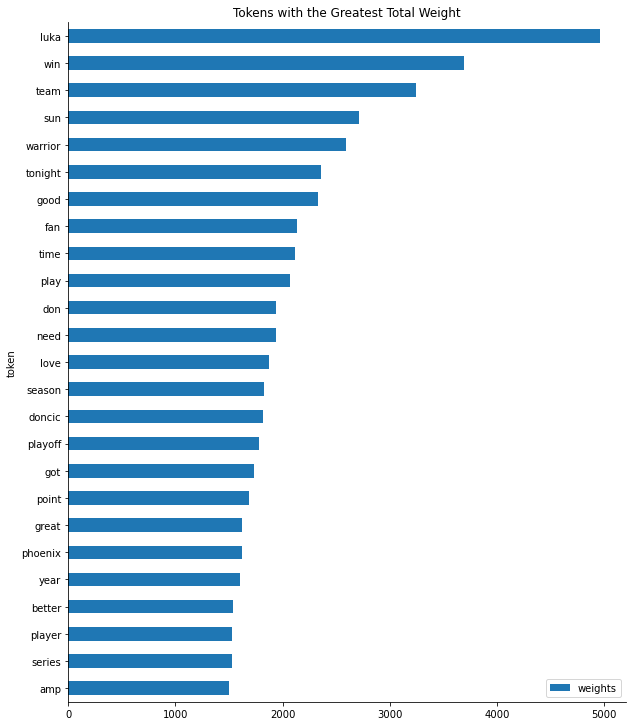

In [97]:
plot_most_frequent(bagofwords, mavs_tweets, 25)

The lemmitization seems to be a better approach here.  While many of the tokens are the same from stemming, some tokens that were more generalized (play, good, watch, look) had smaller weights while some got more specific (play and player are on the lemmitization list).

<a id = 'prepping'></a>

## 4. Prepping Data Ready for Modeling

To be prepared for modeling I will:

1. Transfrom the `Clean_Text` on the Test data using the trained vectorizor.

2. Remove the `Clean_Text` column from both the Train and Test sets.

3. Combine dense array of vectorized words to original dataframes.

In [98]:
mavs_tweets_test = bagofwords.transform(X_test['Clean_Text'])

In [99]:
X_train = X_train.drop(columns = ['Clean_Text'])
X_test = X_test.drop(columns = ['Clean_Text'])

In [100]:
X_train.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,Win,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES,Tweets_Weekly,Tweets_Monthly,Tweets_Infrequent
0,0,0,0,30,505,0,0,1,0,12,...,0,0,0.617647,0,0,0,0,0,0,0
1,0,0,1,642,4980,0,0,0,0,14,...,0,0,0.583333,0,0,0,1,0,1,0
2,0,0,0,36,337,0,0,0,1,9,...,0,1,0.468750,0,0,0,0,0,0,0
3,0,1,1,15251,5661,1,0,1,0,11,...,0,0,0.622222,0,0,0,1,1,0,0
4,1,0,2,54,375,0,1,0,0,23,...,1,1,0.627660,0,0,0,1,1,0,0


In [101]:
X_test.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,Win,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES,Tweets_Weekly,Tweets_Monthly,Tweets_Infrequent
0,1,0,0,716,789,0,0,0,1,23,...,0,1,0.612245,0,0,0,0,0,1,0
1,0,0,0,167,849,0,0,1,0,4,...,1,1,0.611111,0,1,0,0,0,1,0
2,0,0,0,943,3133,0,1,0,0,22,...,0,0,0.631579,0,1,0,0,0,1,0
3,0,0,0,5584,2222,1,0,0,0,10,...,0,0,0.626374,1,0,0,0,1,0,0
4,0,0,0,9,53,0,0,0,0,10,...,1,1,0.631579,0,1,0,0,0,0,0


In [102]:
token_col = bagofwords.get_feature_names_out()
mavs_tweets_train_dense = mavs_tweets.toarray()

In [103]:
mavs_tweets_train_df = pd.DataFrame(columns = token_col, data = mavs_tweets_train_dense)

In [104]:
X_train_full = pd.concat([X_train, mavs_tweets_train_df], axis = 1)

In [105]:
mavs_tweets_test_dense = mavs_tweets_test.toarray()

In [106]:
mavs_tweets_test_df = pd.DataFrame(columns = token_col, data = mavs_tweets_test_dense)

In [107]:
X_test_full = pd.concat([X_test, mavs_tweets_test_df], axis = 1)

In [108]:
X_train_full.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,yes yes yes,yessir,yesterday,yo,york,york knicks,young,yr,zero,zone
0,0,0,0,30,505,0,0,1,0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,642,4980,0,0,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,36,337,0,0,0,1,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,1,15251,5661,1,0,1,0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,2,54,375,0,1,0,0,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
X_test_full.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,yes yes yes,yessir,yesterday,yo,york,york knicks,young,yr,zero,zone
0,1,0,0,716,789,0,0,0,1,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0,0,0,167,849,0,0,1,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0,0,0,943,3133,0,1,0,0,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594783,0.0,0.0
3,0,0,0,5584,2222,1,0,0,0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0,0,0,9,53,0,0,0,0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [110]:
X_train_full.isnull().sum().sum()

0

In [111]:
X_test_full.isnull().sum().sum()

0

### Exporting Data For Modeling

This is what was accomplished in this notebook:

1. Engineered several features to bin/dummy appropriate columns
2. Transformed other columns (such as Usernames) to maximize the usefulness of the data that is left.
3. Train/Test split on the full dataset.
4. Used TFIDF Vectorization on the training data in order to transform all of the tweets to be ready for modeling.

With this, I will export the features and the target variable for the training and testing as individual pickle files to be transferred into a new notebook to do more extensive EDA, model the data to predict the `Sentiment` of tweets.

In [112]:
with open('mavs_X_train.pickle', 'wb') as f:
    pickle.dump(X_train_full, f)

In [113]:
with open('mavs_y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

In [114]:
with open('mavs_X_test.pickle', 'wb') as f:
    pickle.dump(X_test_full, f)

In [115]:
with open('mavs_y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)